In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations

#import samplers as spl

In [2]:
df = pd.read_csv("data/nyt1.csv")

In [3]:
df.head()

,Age,Gender,Impressions,Clicks,Signed_In
0,36,0,3,0,1
1,73,1,3,0,1
2,30,0,3,0,1
3,49,1,3,0,1
4,47,1,11,0,1


In [4]:
df.columns

Index(['Age', 'Gender', 'Impressions', 'Clicks', 'Signed_In'], dtype='object')

In [5]:
df = df[df.Impressions != 0]
df["CTR"] = df['Clicks']/ df['Impressions']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455375 entries, 0 to 458440
Data columns (total 6 columns):
Age            455375 non-null int64
Gender         455375 non-null int64
Impressions    455375 non-null int64
Clicks         455375 non-null int64
Signed_In      455375 non-null int64
CTR            455375 non-null float64
dtypes: float64(1), int64(5)
memory usage: 24.3 MB


In [6]:
def plot_hist(df, title):
    df.hist(['Age','Gender', 'Impressions','Clicks', 'Signed_In',],bins=4,layout=(2,3), 
            figsize=(12,5))
    plt.suptitle(title, size=18, weight='bold')

plt.show()

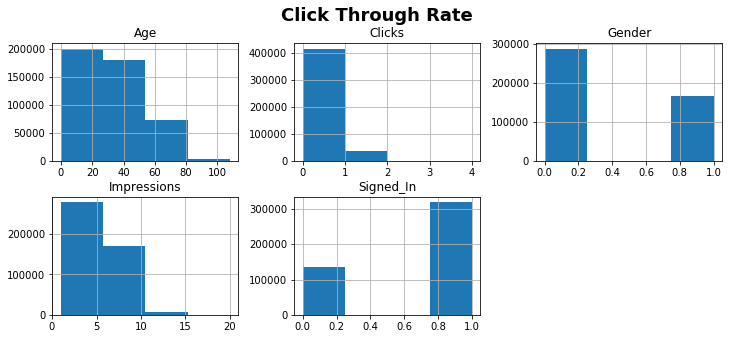

In [7]:
plot_hist(df, "Click Through Rate")

In [8]:
# Two data frames created for signed in and not signed in
signdf = df[df.Signed_In == 1].copy()

notsigndf = df[df.Signed_In == 0].copy()

The CTR (Click Through Rate) is higher with the users that signed in. This is worthy of more investigation.

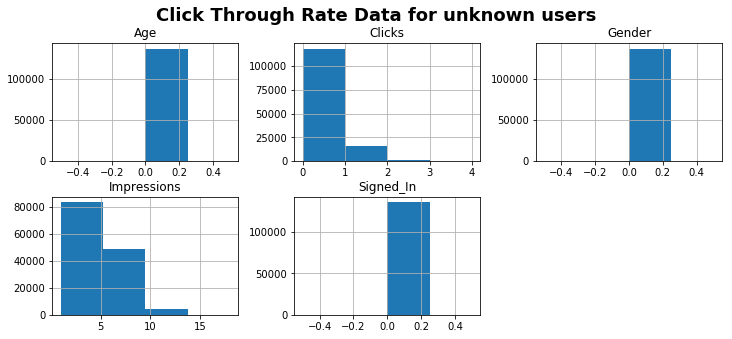

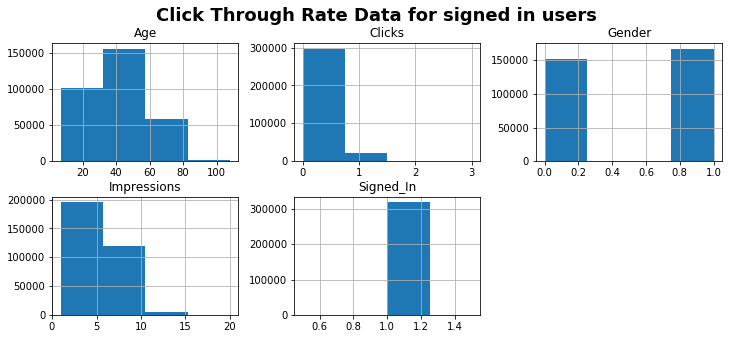

In [9]:


plot_hist(notsigndf, "Click Through Rate Data for unknown users")
plot_hist(signdf, "Click Through Rate Data for signed in users")


In [10]:
stats.ttest_ind(signdf.CTR, notsigndf.CTR, equal_var=False)


Ttest_indResult(statistic=-55.376117934260868, pvalue=0.0)

In [11]:
def plot_t_test(group_1_df, group_2_df, group_1_name, group_2_name):
    fig = plt.figure()
    group_1_mean = group_1_df['CTR'].mean()
    group_2_mean = group_2_df['CTR'].mean()

    print ('%s Mean CTR: %s' % (group_1_name, group_1_mean))
    print ('%s Mean CTR: %s' % (group_2_name, group_2_mean))
    print ('diff in mean:', abs(group_2_mean-group_1_mean))
    p_val = stats.ttest_ind(group_1_df['CTR'], group_2_df['CTR'], equal_var=False)[1]
    print ('p value is:', p_val)

    group_1_df['CTR'].hist(normed=True, label=group_1_name, color='b', alpha=0.3)
    group_2_df['CTR'].hist(normed=True, label=group_2_name, color='r', alpha=0.3)
    plt.axvline(group_1_mean, color='r', alpha=0.6, lw=2)
    plt.axvline(group_2_mean, color='b', alpha=0.6, lw=2)

    plt.ylabel('Probability Density')
    plt.xlabel('CTR')
    plt.legend()
    plt.grid('off')
    plt.show()



In [ ]:
male = signdf[signdf.Gender == 1]
female = signdf[signdf.Gender == 0]

The male vs female for CTR has no impact of variation between the two

m Mean CTR: 0.01391852429759764
f Mean CTR: 0.014622012183866056
diff in mean: 0.0007034878862684155
p value is: 0.00100285273131


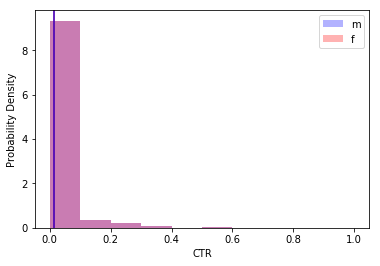

In [13]:
plot_t_test(male, female, 'm', 'f')

In [19]:
signdf['age_groups'] = pd.cut(signdf['Age'], [7, 18, 24, 34, 44, 54, 64, 1000])

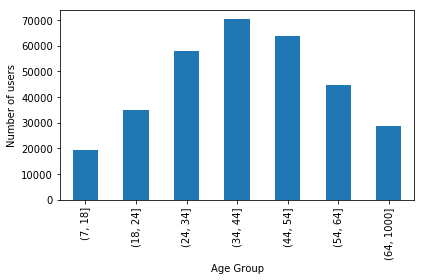

In [20]:
signdf['age_groups'].value_counts().sort_index().plot(kind='bar', grid=False)
plt.xlabel('Age Group')
plt.ylabel('Number of users')
plt.tight_layout()
plt.show()

In [24]:
results = pd.DataFrame()
combos = combinations(pd.unique(signdf['age_groups']), 2)
alpha = 0.3

for age_group_1, age_group_2 in combos:
    age_group_1_ctr = signdf[signdf.age_groups == age_group_1]['CTR']
    age_group_2_ctr = signdf[signdf.age_groups == age_group_2]['CTR']
    
    p_value = stats.ttest_ind(age_group_1_ctr, age_group_2_ctr, equal_var=True)[1]
    age_group_1_ctr_mean = age_group_1_ctr.mean()
    age_group_2_ctr_mean = age_group_2_ctr.mean()
    diff = age_group_1_ctr_mean - age_group_2_ctr_mean
    absolute_diff = abs(age_group_1_ctr_mean - age_group_2_ctr_mean)
    results = results.append({'first_age_group':age_group_1, 'second_age_group':age_group_2, 
              'first_group_mean':age_group_1_ctr_mean, 'second_group_mean':age_group_2_ctr_mean,
              'mean_diff':diff, 'absolute_mean_diff':absolute_diff, 'p_value':p_value},
              ignore_index=True)
    
results = results[['first_age_group', 'second_age_group', 
                   'first_group_mean', 'second_group_mean', 
                   'mean_diff', 'absolute_mean_diff', 'p_value']]
    
results[results['p_value'] < alpha].sort_values('absolute_mean_diff', ascending=False)
results[results['p_value'] < alpha].sort_values('p_value', ascending=False)
results[results['p_value'] > alpha].sort_values('absolute_mean_diff', ascending=False)
results[results['p_value'] > alpha].sort_values('p_value', ascending=False)

,first_age_group,second_age_group,first_group_mean,second_group_mean,mean_diff,absolute_mean_diff,p_value
1,"(34, 44]","(24, 34]",0.010286,0.010146,0.000140,0.000140,0.624837
13,"(24, 34]","(44, 54]",0.010146,0.009958,0.000189,0.000189,0.514327
19,"(44, 54]","(18, 24]",0.009958,0.009720,0.000237,0.000237,0.476879


Each '(64, 1000]', '(7, 18]' and '(54, 64]' age group
has CTR significantly greater than than the other 4 age groups
(i.e., '(18, 24]', '(24, 34]', '(34, 44]', and '(44, 54]').
So the oldest 2 groups and the youngest group are the mostly
likely to click through.

While '(64, 1000]' has a higher CTR than '(7, 18]' which in turn has a
higher CTR than '(54, 64]' and the differences are all statistically
significant, they are less significant than that between the others.

Perhaps the oldest groups are more prone to click through to read an
article,  but do less browsing overall. On the other hand, the youngest
group may be less directed but more active and superficial in their clicking.

The differences in CTR between '(18, 24]', '(24, 34]', '(34, 44]' and '(44, 54]'
are not significant. This indicates the users aged from 18 - 54 are clicking
through at similar ratios. This may be due to similar browsing behavior. I.e.,
they may be at work and scanning through a lot of articles in between tasks,
but not clicking through into the articles to actually read them.